## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

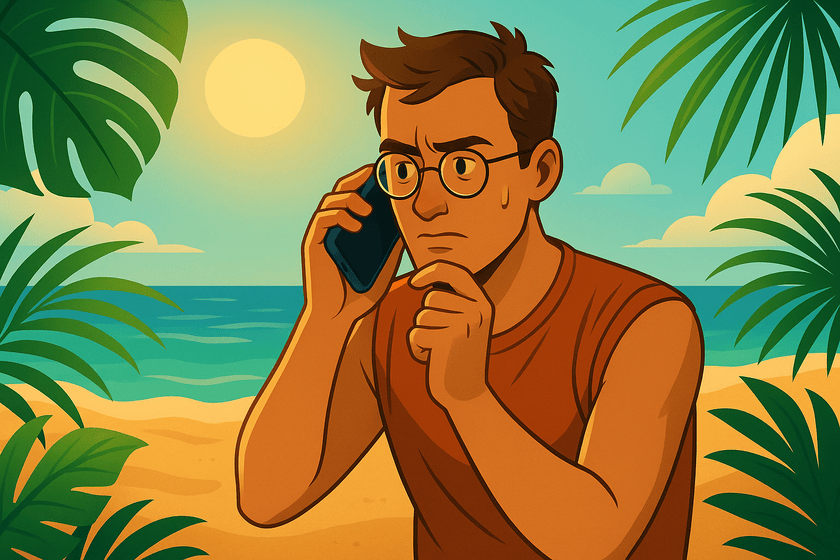

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


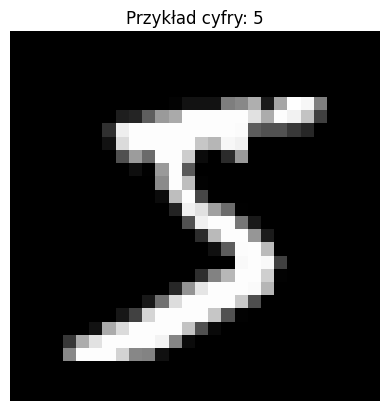

In [1]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()



Obserwacje z 1 zadania:
Nie zawsze się opłaca używać wszystkich danych.

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#tu zależnie od resource jakie macie na collabie - darmowe jest CPU, ale można sobie dokupić zasoby obliczeniowe
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# transformacje: tensory + normalizacja (średnia/odchylenie MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# pobranie danych (zapisze do folderu ./data)
data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

# podział danych na train/val
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128 # można zmienić na mniejszy - jeśli nie będzie działać (out of memory error), to TRZEBA zmienić na mniejszy (16,32,64)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 606kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]


(55000, 5000, 10000)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


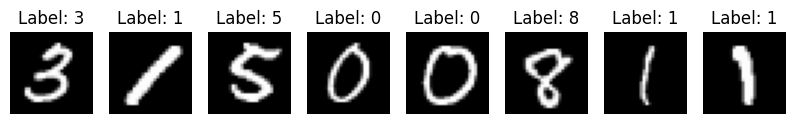

In [4]:
images, labels = next(iter(train_loader))
images = images[:8]
labels = labels[:8]

fig, axes = plt.subplots(1, len(images), figsize=(10, 6))
for ax, img, lab in zip(axes, images, labels):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {lab.item()}")
    ax.axis("off")
plt.show()

**Definicje funkcji**

In [5]:
def run_epoch(loader, train: bool, model, optimizer=None, criterion=None):



  # jak epochy wpływają na wynik?
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

In [6]:
from torch.optim import Adam
def train(model, val_loader,train_loader):
  EPOCHS = 5
  lr = 1e-3


  optimizer = Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
  start = time.time()
  for epoch in range(1, EPOCHS+1):
      tr_loss, tr_acc = run_epoch(train_loader, train=True, model=model, optimizer=optimizer, criterion=criterion)
      va_loss, va_acc = run_epoch(val_loader, train=False, model=model,  optimizer=optimizer, criterion=criterion)
      history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
      history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
      print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
  print(f"Czas treningu: {time.time()-start:.1f}s")

  return history

In [7]:
def history_plot(history):
  plt.figure(figsize=(6,6))
  plt.plot(history["train_loss"], label="train loss")
  plt.plot(history["val_loss"], label="val loss")
  plt.xlabel("Epoka")
  plt.ylabel("Strata")
  plt.legend()
  plt.show()

  plt.figure(figsize=(6,4))
  plt.plot(history["train_acc"], label="train acc")
  plt.plot(history["val_acc"], label="val acc")
  plt.xlabel("Epoka")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


In [8]:
def evaluate(model, device, loader):


  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
      for xb, yb in test_loader:
          xb = xb.to(device, non_blocking=True)
          logits = model(xb)
          preds = logits.argmax(1).cpu().numpy()
          all_preds.append(preds)
          all_targets.append(yb.numpy())

  y_pred = np.concatenate(all_preds)
  y_true = np.concatenate(all_targets)

  test_acc = (y_pred == y_true).mean()
  print(f"Test accuracy: {test_acc:.4f}")


  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest')
  plt.title("Confusion Matrix (MNIST)")
  plt.colorbar()
  tick_marks = np.arange(10)
  plt.xticks(tick_marks, tick_marks)
  plt.yticks(tick_marks, tick_marks)

  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('Prawdziwa klasa')
  plt.xlabel('Predykcja')
  plt.tight_layout()
  plt.show()

  print(classification_report(y_true, y_pred, digits=4))
  return test_acc

In [9]:
def prediction_plot(model):
  model.eval()
  images, labels = next(iter(test_loader))
  images, labels = images[:8], labels[:8]
  with torch.no_grad():
      logits = model(images.to(device))
  preds = logits.argmax(1).cpu()

  fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
  for ax, img, y, p in zip(axes, images, labels, preds):
      ax.imshow(img.squeeze().numpy(), cmap="gray")
      ax.set_title(f"y={y.item()} / p={int(p)}")
      ax.axis("off")
  plt.show()

**Baseline**

In [10]:
class Baseline(nn.Module):
    # 2. Zdefiniuj warstwy i funkcje aktywacji w __init__
    def __init__(self, input_size=28*28, hidden_size=256, output_size=10):
        super(Baseline, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # Pierwsza warstwa liniowa
        self.relu = nn.ReLU()                       # Funkcja aktywacji ReLU
        self.fc2 = nn.Linear(hidden_size, output_size) # Druga warstwa liniowa

    # 3. Zaimplementuj przepływ danych w forward
    def forward(self, x):
        # Spłaszcz tensor wejściowy do rozmiaru (batch_size, input_size)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)    # Przepuść dane przez pierwszą warstwę liniową
        x = self.relu(x)   # Zastosuj funkcję aktywacji ReLU
        x = self.fc2(x)    # Przepuść dane przez drugą warstwę liniową
        return x

modelBaseline = Baseline().to(device)

Przy testach modelów będę używać validation accuracy i test accuracy jako metryki dokładności modelu, ponieważ bazuje ona na danych walidacyjnych i testowych, a nie treningowych.

Ep 01/5 | train loss 0.2784 acc 0.9184 | val loss 0.1556 acc 0.9528
Ep 02/5 | train loss 0.1155 acc 0.9665 | val loss 0.1077 acc 0.9672
Ep 03/5 | train loss 0.0763 acc 0.9769 | val loss 0.0947 acc 0.9704
Ep 04/5 | train loss 0.0551 acc 0.9835 | val loss 0.0855 acc 0.9726
Ep 05/5 | train loss 0.0419 acc 0.9870 | val loss 0.0799 acc 0.9740
Czas treningu: 71.2s


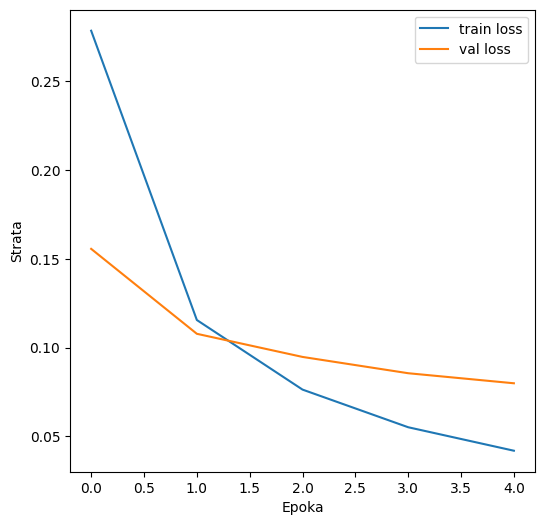

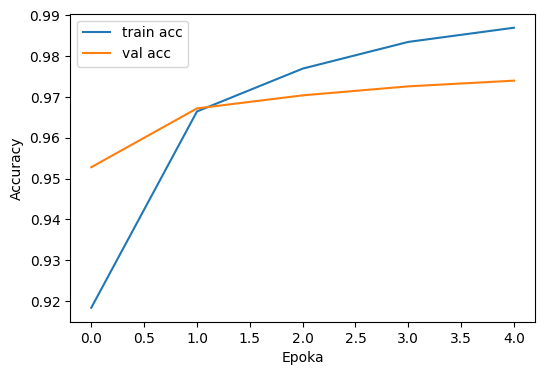

Test accuracy: 0.9751


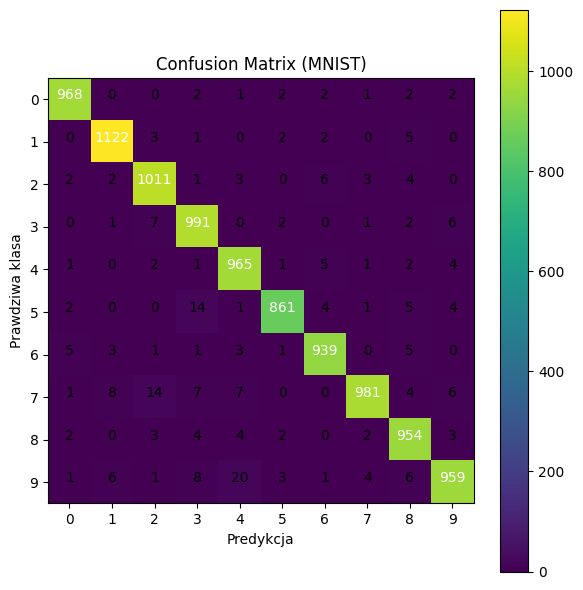

              precision    recall  f1-score   support

           0     0.9857    0.9878    0.9867       980
           1     0.9825    0.9885    0.9855      1135
           2     0.9702    0.9797    0.9749      1032
           3     0.9621    0.9812    0.9716      1010
           4     0.9612    0.9827    0.9718       982
           5     0.9851    0.9652    0.9751       892
           6     0.9791    0.9802    0.9797       958
           7     0.9869    0.9543    0.9703      1028
           8     0.9646    0.9795    0.9720       974
           9     0.9746    0.9504    0.9624      1009

    accuracy                         0.9751     10000
   macro avg     0.9752    0.9749    0.9750     10000
weighted avg     0.9752    0.9751    0.9751     10000



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


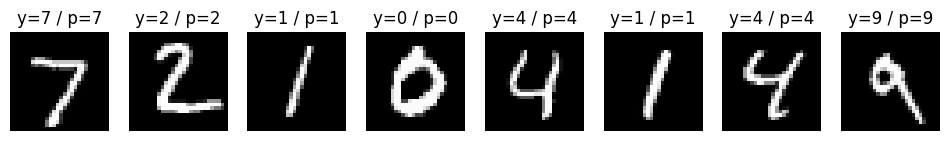

In [11]:
Baseline_history = train(modelBaseline, val_loader,train_loader)
history_plot(Baseline_history)
evaluate(modelBaseline, device, test_loader)
prediction_plot(modelBaseline)

Jak widać model najczęściej myli 7 z 2. Wynik 97,5% accuracy wydaję się dosyć dobry.

Następnie zadeklaruje podstawowego CNNa.

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # przypomnijcie sobie co każda warstwa robi i po co ona jest.
        # tu uwaga przy zmianach cyferek - przypomnijcie sobie matematyczne obliczenie. Musi się zgadzać pomiędzy warstwami.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        # eksperymentujcie z wartościami
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
      # przypomnij sobie czym jest f. aktywacji ReLU
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

modelCNN = SimpleCNN().to(device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 0.1687 acc 0.9475 | val loss 0.0618 acc 0.9816
Ep 02/5 | train loss 0.0675 acc 0.9787 | val loss 0.0469 acc 0.9858
Ep 03/5 | train loss 0.0513 acc 0.9840 | val loss 0.0403 acc 0.9892
Ep 04/5 | train loss 0.0416 acc 0.9871 | val loss 0.0386 acc 0.9888
Ep 05/5 | train loss 0.0354 acc 0.9886 | val loss 0.0353 acc 0.9896
Czas treningu: 369.0s


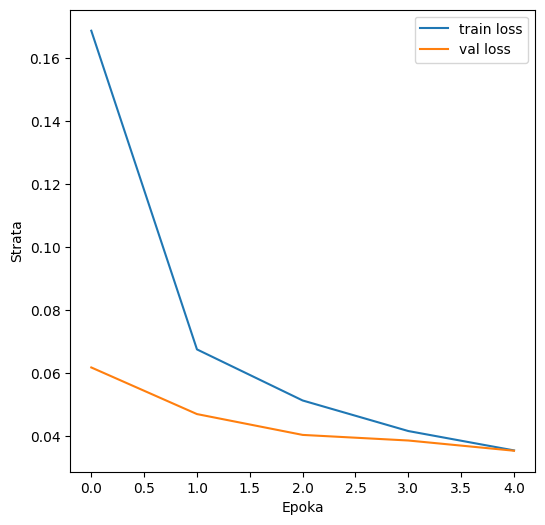

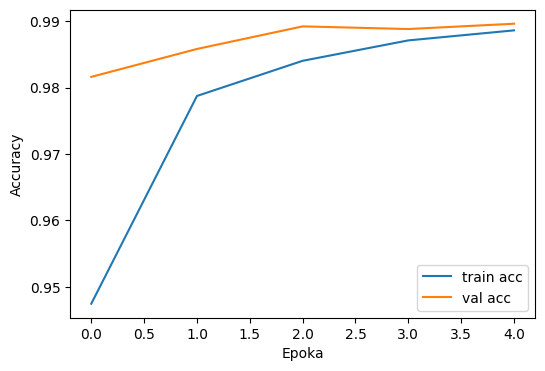

Test accuracy: 0.9920


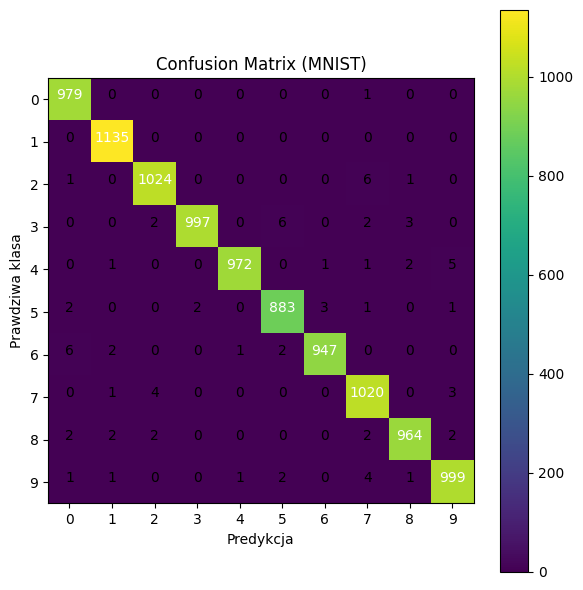

              precision    recall  f1-score   support

           0     0.9879    0.9990    0.9934       980
           1     0.9939    1.0000    0.9969      1135
           2     0.9922    0.9922    0.9922      1032
           3     0.9980    0.9871    0.9925      1010
           4     0.9979    0.9898    0.9939       982
           5     0.9888    0.9899    0.9894       892
           6     0.9958    0.9885    0.9921       958
           7     0.9836    0.9922    0.9879      1028
           8     0.9928    0.9897    0.9913       974
           9     0.9891    0.9901    0.9896      1009

    accuracy                         0.9920     10000
   macro avg     0.9920    0.9919    0.9919     10000
weighted avg     0.9920    0.9920    0.9920     10000



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


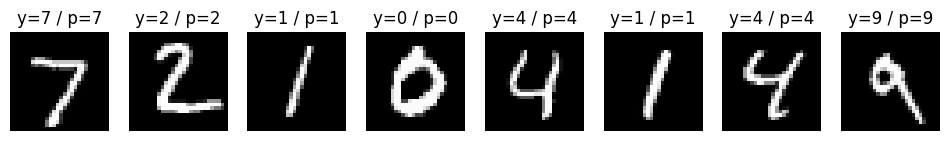

In [14]:
history = train(modelCNN, val_loader,train_loader)
history_plot(history)
evaluate(modelCNN, device, test_loader)
prediction_plot(modelCNN)

Wynik odpowiednio 98,9% i 99,2% jest bardzo dobry pod względem dokładności. Następnie zmienię parametry wyjścia i droput. Dodam również BatchNorm.

In [18]:
class SimpleCNN2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # przypomnijcie sobie co każda warstwa robi i po co ona jest.
        # tu uwaga przy zmianach cyferek - przypomnijcie sobie matematyczne obliczenie. Musi się zgadzać pomiędzy warstwami.
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2, 2)
        # eksperymentujcie z wartościami
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2  = nn.Linear(256, num_classes)

    def forward(self, x):
      # przypomnij sobie czym jest f. aktywacji ReLU
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

modelCNN2 = SimpleCNN2().to(device)

Ep 01/5 | train loss 0.1637 acc 0.9489 | val loss 0.0519 acc 0.9852
Ep 02/5 | train loss 0.0542 acc 0.9827 | val loss 0.0408 acc 0.9882
Ep 03/5 | train loss 0.0394 acc 0.9874 | val loss 0.0351 acc 0.9876
Ep 04/5 | train loss 0.0318 acc 0.9897 | val loss 0.0400 acc 0.9856
Ep 05/5 | train loss 0.0244 acc 0.9921 | val loss 0.0323 acc 0.9902
Czas treningu: 965.3s


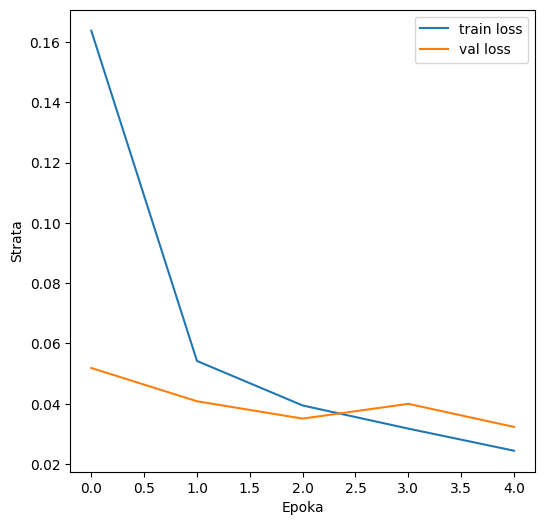

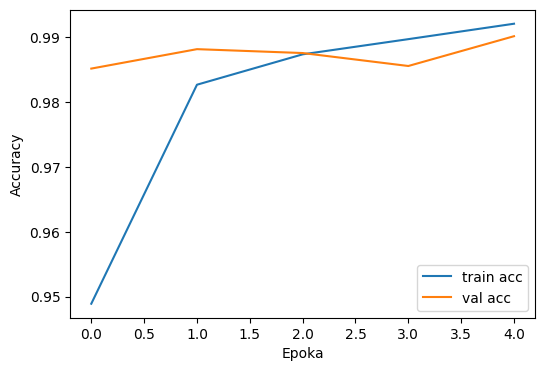

Test accuracy: 0.9918


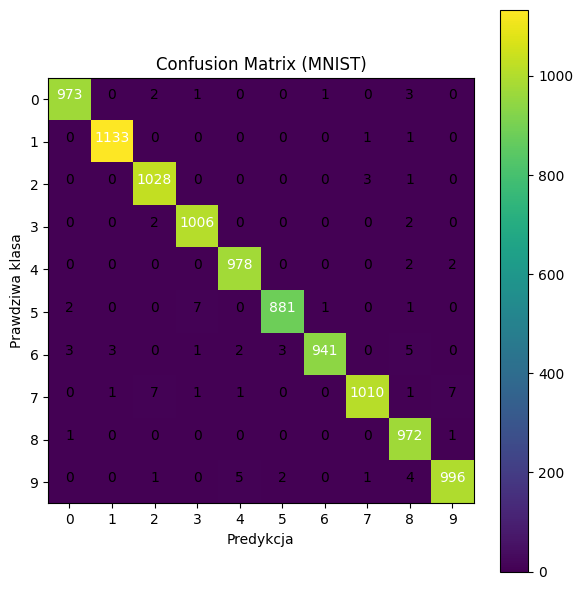

              precision    recall  f1-score   support

           0     0.9939    0.9929    0.9934       980
           1     0.9965    0.9982    0.9974      1135
           2     0.9885    0.9961    0.9923      1032
           3     0.9902    0.9960    0.9931      1010
           4     0.9919    0.9959    0.9939       982
           5     0.9944    0.9877    0.9910       892
           6     0.9979    0.9823    0.9900       958
           7     0.9951    0.9825    0.9887      1028
           8     0.9798    0.9979    0.9888       974
           9     0.9901    0.9871    0.9886      1009

    accuracy                         0.9918     10000
   macro avg     0.9918    0.9917    0.9917     10000
weighted avg     0.9918    0.9918    0.9918     10000



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


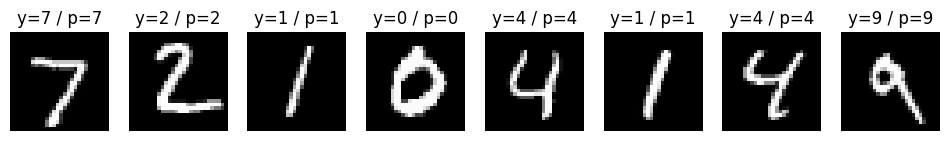

In [19]:
history = train(modelCNN2, val_loader,train_loader)
history_plot(history)
evaluate(modelCNN2, device, test_loader)
prediction_plot(modelCNN2)

Jak widać dokładność modelu wzrosła do odpowiednio 99% i 99,2%.
Następnie do tego modelu dodam kolejną warstwę i sprawdzę wyniki.

In [20]:
class SimpleCNN3(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # przypomnijcie sobie co każda warstwa robi i po co ona jest.
        # tu uwaga przy zmianach cyferek - przypomnijcie sobie matematyczne obliczenie. Musi się zgadzać pomiędzy warstwami.
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool  = nn.MaxPool2d(2, 2)
        # eksperymentujcie z wartościami
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2  = nn.Linear(512, num_classes)

    def forward(self, x):
      # przypomnij sobie czym jest f. aktywacji ReLU
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

modelCNN3 = SimpleCNN3().to(device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 0.1642 acc 0.9470 | val loss 0.0524 acc 0.9842
Ep 02/5 | train loss 0.0514 acc 0.9836 | val loss 0.0410 acc 0.9882
Ep 03/5 | train loss 0.0368 acc 0.9883 | val loss 0.0329 acc 0.9902
Ep 04/5 | train loss 0.0293 acc 0.9905 | val loss 0.0319 acc 0.9896
Ep 05/5 | train loss 0.0243 acc 0.9924 | val loss 0.0343 acc 0.9896
Czas treningu: 1353.7s


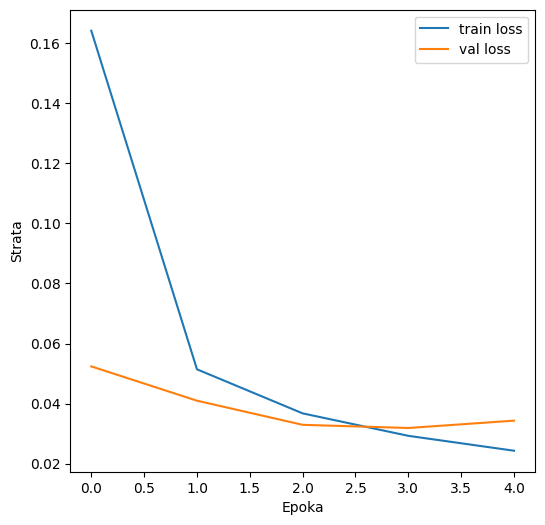

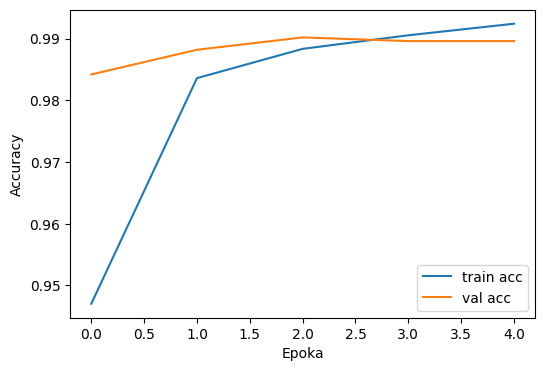

Test accuracy: 0.9902


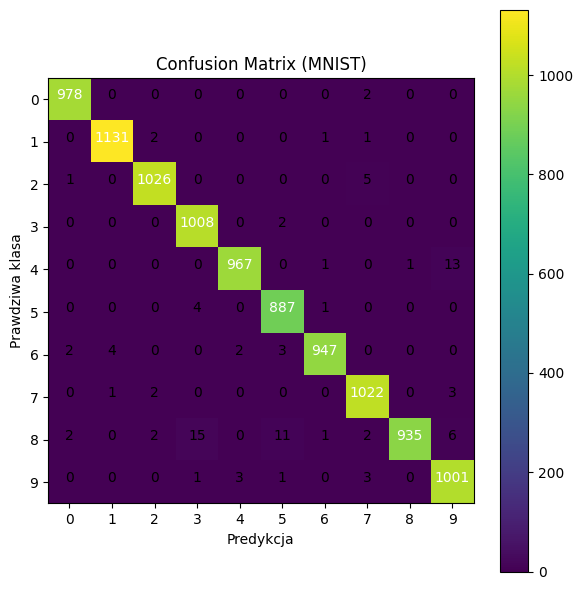

              precision    recall  f1-score   support

           0     0.9949    0.9980    0.9964       980
           1     0.9956    0.9965    0.9960      1135
           2     0.9942    0.9942    0.9942      1032
           3     0.9805    0.9980    0.9892      1010
           4     0.9949    0.9847    0.9898       982
           5     0.9812    0.9944    0.9878       892
           6     0.9958    0.9885    0.9921       958
           7     0.9874    0.9942    0.9908      1028
           8     0.9989    0.9600    0.9791       974
           9     0.9785    0.9921    0.9852      1009

    accuracy                         0.9902     10000
   macro avg     0.9902    0.9900    0.9901     10000
weighted avg     0.9903    0.9902    0.9902     10000



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


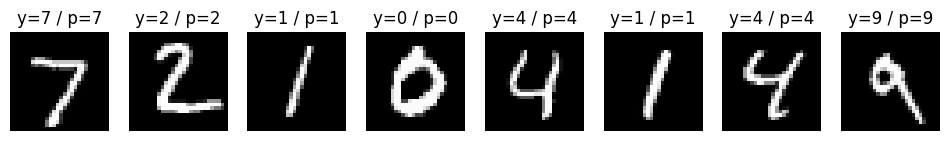

In [21]:
history = train(modelCNN3, val_loader,train_loader)
history_plot(history)
evaluate(modelCNN3, device, test_loader)
prediction_plot(modelCNN3)

Jak widać model przy 3 warstwach po 3 epochy się przeuczył, doszło do zwiększenia dokładności train, lecz do zmniejszenia dokładności zarówno val acc i test acc.

In [22]:

model_save_path = 'simple_nn_state_dict.pth'
torch.save(modelBaseline.state_dict(), model_save_path)
torch.save(modelCNN.state_dict(), model_save_path)
torch.save(modelCNN2.state_dict(), model_save_path)
torch.save(modelCNN3.state_dict(), model_save_path)

Wnioski:


*   Najdokładniejszym modelem był model CNN2, w który zostały wartości wejściowe i wyjściowe oraz dropout i BatchNorm.
*   Różnica między Baseline, a CNN2 wynosiła ok. 2 pkt procentowe.

*   Nie zawsze opłaca się używać bardziej skomplikowanego modelu i zwiększania warstw. Nie prowadzi to do zwiększenia dokładności, a zajmuje jedynie dużo czasu (prawie 25min trenowania).

